In [1]:
import pandas as pd
import numpy as np
import keras
# import gensim
import matplotlib.pyplot as plt

import spacy

In [2]:
tweetdata = pd.read_csv("data/raw/testdata.manual.2009.06.14.csv", header=None, encoding="ISO-8859-1")

In [3]:
tweetdata.columns = ['polarity', 'id', 'date', 'source', 'username', 'text']

In [5]:
polarity_data = pd.DataFrame(tweetdata['polarity'].values, columns=['polarity'])

In [6]:
# polarity_data.to_csv('data/raw/test_labels.csv')

In [7]:
tweetdata_text_only = pd.read_csv('data/raw/testdata.text_only.csv')

In [10]:
tweetdata.head()

polarity  id                          date   source  username  \
0         4   3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1         4   4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2         4   5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3         4   6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4         4   7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  
1  Reading my kindle2...  Love it... Lee childs i...  
2  Ok, first assesment of the #kindle2 ...it fuck...  
3  @kenburbary You'll love your Kindle2. I've had...  
4  @mikefish  Fair enough. But i have the Kindle2...

### Create Hashtag Tweets Dataset

In [21]:
hashtag_ids = []
for i in range(len(tweetdata[5])):
    if '#' in tweetdata[5][i]:
               hashtag_ids.append(i)

In [22]:
len(hashtag_ids)

36812

In [32]:
len(hashtag_ids)/len(tweetdata)

0.021213531494140625

In [23]:
hashtag_tweets = tweetdata.iloc[hashtag_ids]

In [24]:
len(hashtag_tweets)

36812

In [25]:
# hashtag_tweets.to_csv('hashtag_tweets.36812.csv')

# Cleaning

Note to self: start with naive/convenient implementation. When hosting as a service, look to improve efficiency with faster methods.

A lot of the following is determined by domain, topic, data type, data source, experience, and language.


Remove
- integers
- punctuation
- url
- html tags
- other characters

In [ ]:
# @\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+

In [106]:
# 1/21/19 https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [12]:
original_tweetdata = tweetdata.copy()

In [107]:
tweetdata = standardize_text(tweetdata, 'text')

In [14]:
original_tweetdata.head()

polarity  id                          date   source  username  \
0         4   3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1         4   4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2         4   5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3         4   6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4         4   7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  
1  Reading my kindle2...  Love it... Lee childs i...  
2  Ok, first assesment of the #kindle2 ...it fuck...  
3  @kenburbary You'll love your Kindle2. I've had...  
4  @mikefish  Fair enough. But i have the Kindle2...

In [15]:
original_tweetdata.text[5]

"@richardebaker no. it is too big. I'm quite happy with the Kindle2."

In [16]:
tweetdata.text[5]

" no  it is too big  i'm quite happy with the kindle2 "

In [31]:
# tweetdata.to_csv("1600000.cleaned.url.at.csv")

# Preprocessing

In [8]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tweetdata["tokens"] = tweetdata["text"].apply(tokenizer.tokenize)
tweetdata.head()

polarity  id                          date   source  username  \
0         4   3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1         4   4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2         4   5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3         4   6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4         4   7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  \
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...   
1  Reading my kindle2...  Love it... Lee childs i...   
2  Ok, first assesment of the #kindle2 ...it fuck...   
3  @kenburbary You'll love your Kindle2. I've had...   
4  @mikefish  Fair enough. But i have the Kindle2...   

                                              tokens  
0  [stellargirl, I, loooooooovvvvvveee, my, Kindl...  
1  [Reading, my, kindle2, Love, it, Lee, childs, ...  
2  [Ok, first, assesment, of, the, kindle2, it, f...  
3  [kenburbary, You, ll, love, your, Kindle2, I, ...  
4  [mikefish, Fair, enough, But, i, have, the, Ki...

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in tweetdata["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in tweetdata["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

Using TensorFlow backend.


7291 words total, with a vocabulary size of 2692
Max sentence length is 31


In [19]:
tweetdata.groupby('polarity').count()

id  date  source  username  text  tokens
polarity                                           
0         177   177     177       177   177     177
2         139   139     139       139   139     139
4         182   182     182       182   182     182

# Embedding

In [10]:
nlp = spacy.load('en_vectors_web_lg')

In [11]:
nlp.vocab.length

1071393

In [12]:
nlp.vocab.get_vector('hello').shape

(300,)

In [79]:
padded_data = []
for tweet in tweetdata.tokens:
    pad_length = 31 - len(tweet)
    padded_data.append(np.pad(tweet, (0, pad_length), 'constant', constant_values='not_in_vector'))

In [80]:
type_padded_data = []
for tweet in padded_data:
    new_tweet = []
    for word in tweet:
        new_tweet.append(str(word))       
    type_padded_data.append(new_tweet)

In [86]:
embedding_matrix = []
for tweet in type_padded_data:
    embedded_tweet = []
    for word in tweet:
        if word != 'not_in_vector':
            embedding_vector = nlp.vocab.get_vector(word)
            if embedding_vector is not None:
                embedded_tweet.append(embedding_vector)   
        else:
            embedding_vector = np.zeros(300)
            embedded_tweet.append(embedding_vector)
    embedding_matrix.append(embedded_tweet)

In [6]:
# tweetdata = pd.read_csv("1600000.cleaned.url.at.csv", index_col=0)

/Users/rexlintc/anaconda/envs/cs61c/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [29]:
list_corpus = test.text.tolist()

In [30]:
count_embedding, count_vectorizer = cv(list_corpus)

In [31]:
count_embedding

<498x1985 sparse matrix of type '<class 'numpy.int64'>'
	with 5772 stored elements in Compressed Sparse Row format>

In [92]:
test = np.array(embedding_matrix)

In [94]:
test1 = test.tolist()

In [100]:
from sklearn.model_selection import train_test_split
# list_corpus = tweetdata["text"].tolist()
list_labels = tweetdata["polarity"].tolist()

X_train, X_test, y_train, y_test = train_test_split(test1, list_labels, test_size=0.2, 
                                                                                random_state=40)

# X_train_counts, count_vectorizer = cv(X_train)
# X_test_counts = count_vectorizer.transform(X_test)

In [111]:
from keras.preprocessing.text import Tokenizer

In [109]:
tweet_doc = tweetdata.text.tolist()

In [113]:
t = Tokenizer()
t.fit_on_texts(tweet_doc)

In [115]:
len(t.word_index)

2061

In [119]:
t.texts_to_sequences(tweet_doc)

[[2, 705, 9, 44, 29, 27, 1, 322, 5, 248, 34, 1, 69, 5, 706, 11, 84, 432, 197],
 [135, 9, 44, 26, 12, 707, 708, 5, 24, 163],
 [249, 323, 709, 10, 1, 44, 12, 250, 433],
 [710,
  26,
  70,
  44,
  198,
  106,
  711,
  8,
  4,
  324,
  712,
  6,
  123,
  434,
  71,
  1,
  18,
  199,
  85,
  5,
  435,
  93,
  164,
  8,
  713],
 [714, 436, 34, 2, 19, 1, 44, 6, 2, 251, 59, 437],
 [93, 12, 5, 107, 199, 32, 325, 136, 13, 1, 44],
 [438, 33, 439, 2, 48, 124, 6, 440, 715, 716, 441, 717],
 [37, 5, 9, 18, 74, 442],
 [718, 49],
 [94, 95, 15, 29, 26, 72, 78, 252, 326, 38, 719],
 [327, 33, 165, 45, 328, 72, 7, 1, 253, 254, 720, 166],
 [2,
  721,
  443,
  27,
  72,
  200,
  19,
  722,
  723,
  3,
  41,
  724,
  59,
  4,
  725,
  6,
  4,
  255,
  34,
  65,
  86,
  3,
  726,
  727],
 [254, 728, 166, 22, 108, 20, 729, 730, 25, 731, 167, 72, 39, 4, 732, 733],
 [734, 444, 735, 201, 33, 18, 30, 736, 13, 4, 737, 42, 738, 61, 22, 445, 446],
 [739, 30, 329, 13, 1, 740, 27, 168, 5, 4, 447, 10, 448, 6, 741, 26],
 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('../glove_data/glove.6B/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model

In [103]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_test)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.660, precision = 0.665, recall = 0.660, f1 = 0.659


In [46]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

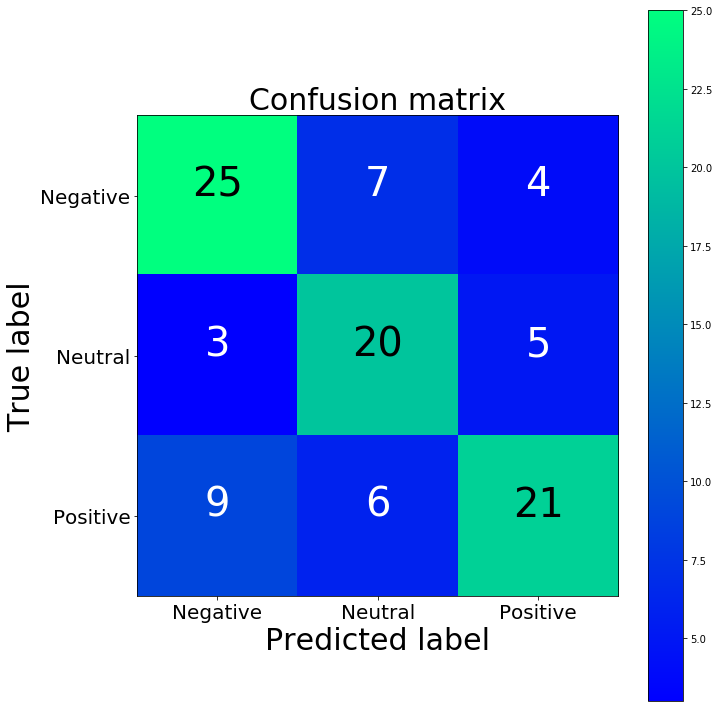

[[25  7  4]
 [ 3 20  5]
 [ 9  6 21]]


In [47]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [41]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.", len(model), " words loaded!")
    return model

In [15]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Positive')
            green_patch = mpatches.Patch(color='blue', label='Negative')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

<Figure size 1600x1600 with 1 Axes>

In [55]:
# Hashtag REGEX